<a href="https://colab.research.google.com/github/ktgraze/Mod4ITAI2372/blob/main/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Katherine Stanton \
W210361913
# This notebook explores the Credit Card Fraud Detection Dataset by Machine Learning Group - ULB via Kaggle.


*   Several models are implemented including `Logistic Regression`, `SMOTE`, `XGBoost`, and `IsolationForest`.
*   After observing the performances of each model, we save the highest performing model (`XGBoost`) to load into a Streamlit UI.



In [1]:
# Install dependencies
!pip install kaggle scikit-learn pandas joblib matplotlib seaborn

In [2]:
# Import libraries
import kagglehub
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Connecting to Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"katherinestanton","key":"0cf0ac46d1102b5411ddf5ceb7e7a836"}'}

In [4]:
# Download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzip the file
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
# Load and explore the dataset
df = pd.read_csv('creditcard.csv')
print(df.head())
print(df.info())
print(df['Class'].value_counts()) # Check class distribution

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# **Dataset explained**:
The *credit car fraud detection* dataset from Kaggle contains **284,807** transactions, with each row representing a credit card transaction. The dataset has **30 columns**, including:


*   Time
*   V1, V2, ...,V28: Anonymized numerical features obtained using Principal Component Analysis (PCA).
* Amount
* Class: the target variable (0 = Legitimate, 1 = Fraudulent).
* The dataset is highly imbalanced with **284,315** instances of legitimate transactions and **492** instances of fraud.



<ipython-input-7-e9665dbf8a40>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Class'], palette="coolwarm")


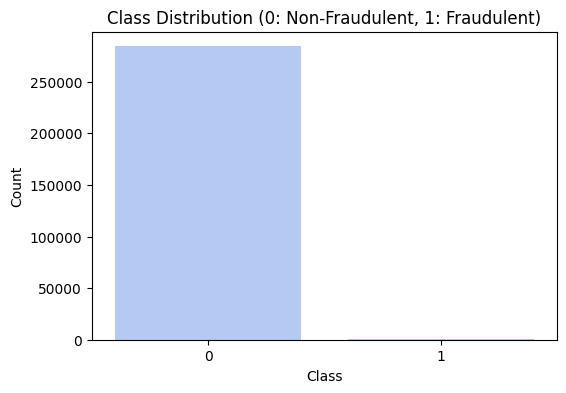

In [7]:
# Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['Class'], palette="coolwarm")
plt.title("Class Distribution (0: Non-Fraudulent, 1: Fraudulent)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

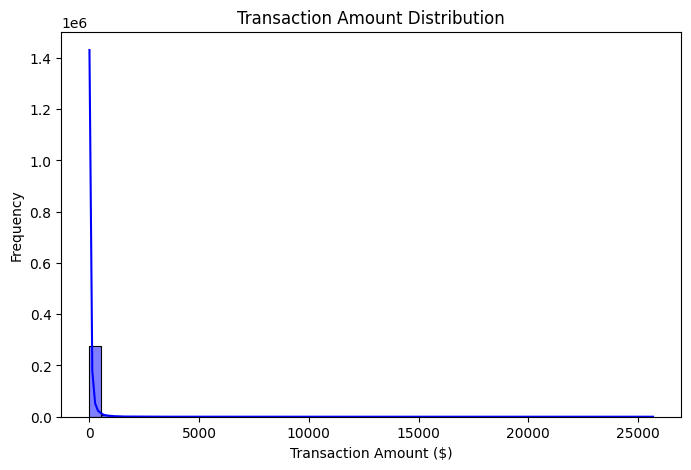

In [8]:
# Transaction Amount Distribution

plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=50, kde=True, color='blue')
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Frequency")
plt.show()

**Insight**: Most transactions are small amounts, with fewer high-value transactions.

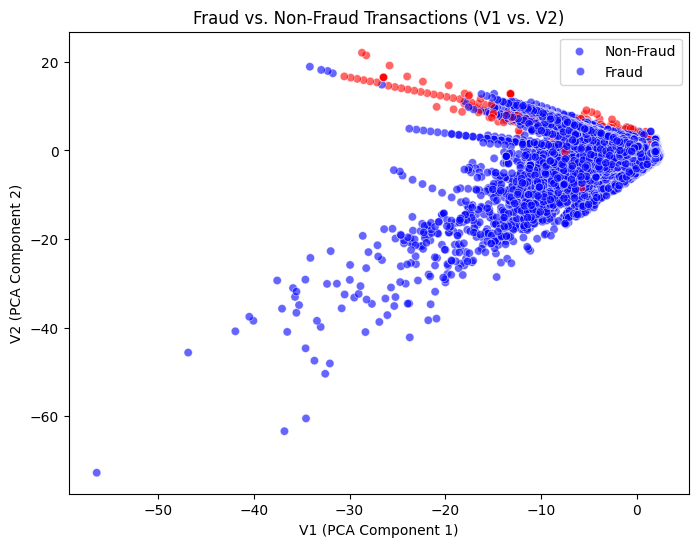

In [9]:
# Visualize how fraud vs. non-fraud transactions differ across selected PCA components (V1, V2, etc.)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['V1'], y=df['V2'], hue=df['Class'], palette={0: "blue", 1: "red"}, alpha=0.6)
plt.title("Fraud vs. Non-Fraud Transactions (V1 vs. V2)")
plt.xlabel("V1 (PCA Component 1)")
plt.ylabel("V2 (PCA Component 2)")
plt.legend(["Non-Fraud", "Fraud"])
plt.show()

**Expected Pattern**:


*   Fraudulent transactions (red points) might cluster in distinct regions.
*   Non-fraud transactions (blue points) are more evenly distributed.



In [10]:
# Split and scale the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression model

In [11]:
# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # make predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9991573329588147
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   35    63]]


**Observations**:

*   **Accuracy**: very high, but misleading due to class imbalance.
*   **Precision**: Almost all predicted 'non-fraud' cases were correct, while 83% of predicted fraud cases were actually fraud.
* **Recall**: Almost all actual non-fraud cases were correctly classified, while the model missed 36% of actual fraud cases.
* **F1-score for fraud**: 0.72 (decent balance between precision and recall).
* **Confusion matrix**: 35 False negatives (missed fraud cases) and 13 False positives (wrongly predicted fraud cases).



## Logistic Regression model adjusted with a `class_weight="balanced"` parameter.

In [12]:
model = LogisticRegression(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9754573224254767
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

[[55474  1390]
 [    8    90]]


Observations:

*   **Accuracy**: lower than first model, but better for fraud detection.
*   **Precision**: Still very high prediction for non-fraud, while false positives increased dramatically.
* **Recall**: Slightly lower non-fraud detection than first model, while fraud detection saw a huge improvement (now catching 92% of fraud cases).
* **F1-score**: low because of low precision.
* **Confusion matrix**: Now only 8 missed fraud cases but with many more false alarms (1390).



## Oversampling with SMOTE
### (Synthetic Minority Over-sampling technique), generates new synthetic cases.

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1     45490
Name: count, dtype: int64


## Undersampling the Majority Class
removes some non-fraud transactions to balance the dataset using `RandomUnderSampler`.

In [14]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

print("After Undersampling: ", pd.Series(y_resampled).value_counts())

After Undersampling:  Class
0    1970
1     394
Name: count, dtype: int64


# Initiate and train an XGBoost model (handles imbalance well)

In [15]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=(len(y_train) / sum(y_train)), random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56854    10]
 [   16    82]]


**Observation**:

*   Model performed very well, detecting more fraud than the first Logistic Regression model and avoiding false positives compared to the balanced Logistic Regression model (10 vs. 1390)



# Deploy an IsolationForest

In [16]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if pred == -1 else 0 for pred in y_pred_iso] # Convert -1 (outliers) to 1 (fraud)

print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.66      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.83      0.59     56962
weighted avg       1.00      0.99      0.99     56962

[[56311   553]
 [   33    65]]


Observations:


*   Treats fraud cases as anomalies and isolates them as outliers.
*   Compared to XGBoost, the model missed twice as many fraud cases and creates many more false fraud alerts (553 vs. 10).



# Save the best model (XGBoost)

In [17]:
import joblib

joblib.dump(xgb_model, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']